In [1]:
import pandas as pd

df = pd.read_csv('data/raw/Telco-Customer-Churn.csv', encoding='utf-8')

In [2]:
df.drop(columns=['customerID'], inplace=True)

In [3]:
df.drop_duplicates(inplace=True)

In [4]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [5]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

print(df['TotalCharges'].isnull().sum())
df = df.dropna(subset=['TotalCharges'])
print(df['TotalCharges'].isnull().sum())

11
0


In [6]:
import numpy as np

df['CLV'] = df['MonthlyCharges'] * df['tenure']

# df['tenure_group'] = pd.cut(df['tenure'], bins=[0, 12, 24, 48, 60, np.inf], labels=['1', '2', '3', '4', '5'])
df['tenure_group'] = pd.cut(df['tenure'], bins=[0, 12, 24, 48, 60, np.inf], labels=['0-12', '13-24', '25-48', '49-60', '61+']).astype(str)

services = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity','OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

df['TotalServices'] = df[services].apply(lambda row: sum(row == 'Yes'), axis=1)

df['Senior_NoPartner'] = ((df['SeniorCitizen'] == 1) & (df['Partner'] == 'No')).astype(int)

df['HasInternet'] = (df['InternetService'] != 'No').astype(int)

df['IsAutoPay'] = df['PaymentMethod'].apply(lambda x: 1 if 'automatic' in x.lower() else 0)

df['StreamingCount'] = df[['StreamingTV', 'StreamingMovies']].apply(lambda row: sum(row == 'Yes'), axis=1)

In [7]:
# 1. Isoler la target
y = df['Churn']
X = df.drop('Churn', axis=1)
from sklearn.preprocessing import LabelEncoder


num_cols = ['MonthlyCharges', 'tenure', 'TotalCharges', 'CLV', 'TotalServices', 'Senior_NoPartner', 'HasInternet', 'IsAutoPay', 'StreamingCount']

num_data = X[num_cols]

categorical_cols = X.drop(columns=num_cols).select_dtypes(include='object').columns
cat_data = pd.get_dummies(X[categorical_cols], drop_first=False)

X = pd.concat([num_data, cat_data], axis=1)

df = pd.concat([X, y], axis=1)

In [8]:
from sklearn.model_selection import train_test_split

X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])

X_test[num_cols] = scaler.transform(X_test[num_cols])

In [11]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

In [12]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced' )
model.fit(X_train_bal, y_train_bal)
# model.fit(X_train, y_train)


y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7924393723252496
Confusion Matrix:
 [[889 142]
 [149 222]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86      1031
           1       0.61      0.60      0.60       371

    accuracy                           0.79      1402
   macro avg       0.73      0.73      0.73      1402
weighted avg       0.79      0.79      0.79      1402



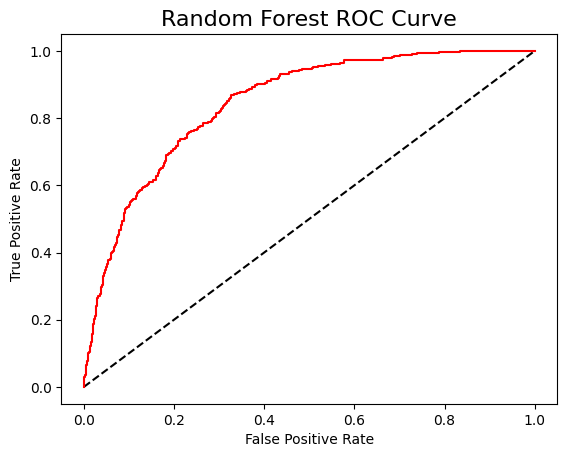

In [13]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
y_rfpred_prob = model.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_rfpred_prob)
plt.plot([0, 1], [0, 1], 'k--' )
plt.plot(fpr_rf, tpr_rf, label='Random Forest',color = "r")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve',fontsize=16)
plt.show()